[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ffuntik/ML_project_5/blob/master/Toy_examples/Toy%20examples%20NNMF.ipynb)

# NNMF with ICNN on toy examples

## Imports

In [10]:
from sklearn.datasets import make_moons, make_circles, make_classification, load_breast_cancer
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import numpy as np
from sklearn.metrics import f1_score
from statistics import mean
from time import time
from sklearn.decomposition import NMF

## Working with datasets

In [11]:
class Data(torch_data.Dataset):
    def __init__(self, X, y):
        super(Data, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return  self.X[idx], self.y[idx]

## ICNN

In [12]:
class ConvexLayer(nn.Module):
    __constants__ = ['input_features', 'output_features', 'weight', 'bias']

    def __init__(self, input_features, output_features, W, H, bias=False, nmf=False):
        super(ConvexLayer, self).__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.W = torch.Tensor(W)
        self.H = torch.Tensor(H)
        self.nmf = nmf
        
        self.weight = nn.Parameter(torch.Tensor(
            torch.rand(output_features, input_features)
        ))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, input):
        if self.nmf == True:
            output = F.linear(input, self.H)
            linear = F.linear(output, self.W, self.bias)
            #linear = F.linear(input, self.W@self.H, self.bias)
        else:
            linear = F.linear(input, self.weight, self.bias)
        return linear

In [13]:
class DenseICNN(nn.Module):
    def __init__(self, input_dim, output_dim,  hidden_layer_sizes, W, H, activation='celu', dropout=0.3, nmf=False):
        super(DenseICNN, self).__init__()
        
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.droput = dropout
        self.activation = activation

        
        self.quadratic_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, output_features, bias=True),
                nn.Dropout(dropout))
            for output_features in hidden_layer_sizes])
        
        sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.convex_layers = nn.ModuleList([
            nn.Sequential(
                ConvexLayer(input_features, output_features, W=W, H=H, bias=False, nmf=nmf),
                nn.Dropout(dropout))
            for (input_features, output_features) in sizes])
        
        self.final_layer = nn.Linear(hidden_layer_sizes[-1], output_dim, bias=False)
        
                        
    def forward(self, input):
        output = self.quadratic_layers[0](input)
        for quadratic_layer, convex_layer in zip(self.quadratic_layers[1:], self.convex_layers):
            output = convex_layer(output) + quadratic_layer(input)
            if self.activation == 'celu':
                output = torch.celu(output)
        return self.final_layer(output)
    
    def convexify(self):
        for layer in ICNN.convex_layers:
            for sublayer in layer:
                if (isinstance(sublayer, ConvexLayer)):
                    sublayer.weight.data.clamp_(0)

## Training procedure

In [14]:
def train(epochs, ICNN, optimizer, train_loader, scheduler=None, verbose=True, save_dir=None):
    
    for epoch in range(1, epochs+1):
        f1 = []
        ICNN.train()
        for X, y in train_loader:
           
            y_out = ICNN(X)
            loss = criterion(y.unsqueeze(1), torch.sigmoid(y_out))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ICNN.convexify()
            
            
        ICNN.eval()
        for X, y in train_loader:
            
            y_out = ICNN(X)
            test_loss = criterion(y.unsqueeze(1), torch.sigmoid(y_out))
            predY_bin = (torch.sigmoid(y_out).detach().numpy() >= 0.55).astype(np.int)
            trueY_bin = np.expand_dims(y.detach().numpy(), axis=1)
            f1.append(f1_score(trueY_bin.T, predY_bin.T, average='micro', pos_label=None))
            
            
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,50)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), test_loss.item()))
            print('F1 score:', mean(f1))

In [15]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [16]:
def NMF_time(ICNN, sample_loader):
    time_ = []
    for X in sample_loader:
        start = time()
        pred = ICNN(X)
        end = time()
        time_.append(end - start)
    return time_

In [17]:
def NMF_score(ICNN, sample_loader):
    for X, y in sample_loader:
        y_out = ICNN(X)
        predY_bin = (torch.sigmoid(y_out).detach().numpy() >= 0.55).astype(np.int)
        trueY_bin = np.expand_dims(y.detach().numpy(), axis=1)
    return f1_score(trueY_bin.T, predY_bin.T, average='micro', pos_label=None)

## Results

Moons dataset:
Epoch 50/200 || Loss:  Train 0.0388 | Validation 0.0234
F1 score: 0.9562281770254607
Epoch 100/200 || Loss:  Train 0.0543 | Validation 0.0171
F1 score: 0.9673266011446252
Epoch 150/200 || Loss:  Train 0.0430 | Validation 0.0270
F1 score: 0.9682767179835751
Epoch 200/200 || Loss:  Train 0.0190 | Validation 0.0221
F1 score: 0.9685543699686135

(100, 1)
(1, 150)
Circles dataset:
Epoch 50/200 || Loss:  Train 0.1549 | Validation 0.0808
F1 score: 0.9497026063162991
Epoch 100/200 || Loss:  Train 0.1199 | Validation 0.0634
F1 score: 0.9476889193119121
Epoch 150/200 || Loss:  Train 0.1381 | Validation 0.0458
F1 score: 0.9596383631137839
Epoch 200/200 || Loss:  Train 0.0873 | Validation 0.0429
F1 score: 0.9631163832891245

(100, 1)
(1, 150)
Classification dataset:
Epoch 50/200 || Loss:  Train 0.0580 | Validation 0.0701
F1 score: 0.9466757629901534
Epoch 100/200 || Loss:  Train 0.0430 | Validation 0.0498
F1 score: 0.9469686972176345
Epoch 150/200 || Loss:  Train 0.0467 | Validation

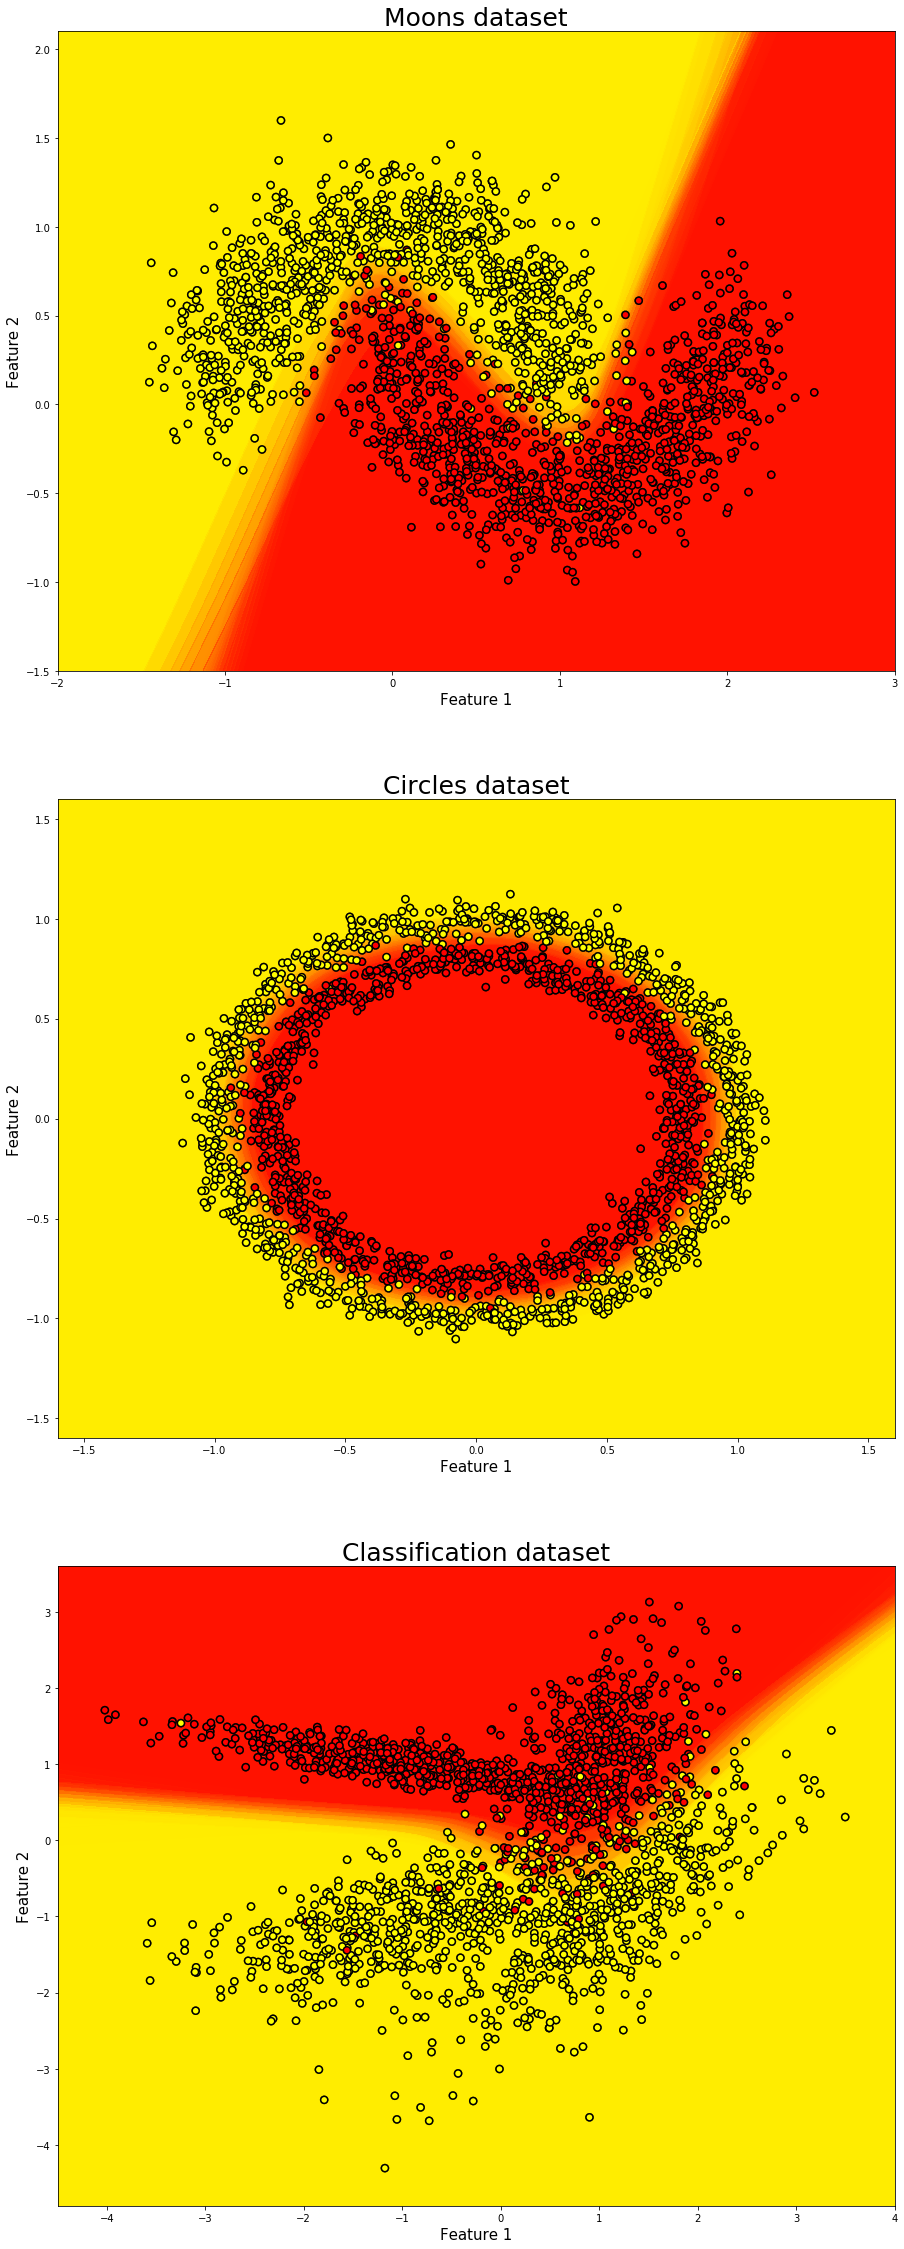

In [18]:
toy_examples = {'Moons': make_moons(n_samples=2000, shuffle=True, noise=0.2, random_state=42),
                'Circles': make_circles(n_samples=2000, shuffle=True, noise=0.05, random_state=42),
                'Classification': make_classification(n_samples=2000, n_features=2, n_redundant=0, n_informative=2, n_classes=2, random_state=27)}
names = ['Moons', 'Circles', 'Classification']

fig, ax = plt.subplots(3, 1, figsize=(15,40))

output_dim = 1
hidden_layer_sizes=[150, 100]

percents = np.linspace(1.0, 10, 10)

time1_ = []
time2_ = []
score1_ = []
score2_ = []
for percent in percents:
    model = NMF(n_components=int(percent), init='random', random_state=0)
    time_1 = []
    time_2 = []
    f1_1 = []
    f1_2 = []

    for i in range(len(names)):
        print(names[i] + ' dataset:')

        x, y = toy_examples[names[i]]
        batch_size_train = x.shape[0]//10
        input_dim = x.shape[1]
        dataset = Data(x, y) 

        ICNN = DenseICNN(input_dim, output_dim,  hidden_layer_sizes, W=1, H=1, activation='celu') 
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(ICNN.parameters(), lr=1e-3) 
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)
        data_loader = torch_data.DataLoader(dataset, batch_size=batch_size_train, shuffle=True) 
        train(200, ICNN, optimizer, data_loader, scheduler)

        print()

        W = model.fit_transform(ICNN.convex_layers[0][0].weight.data.detach().numpy())
        H = model.components_

        print(W.shape)
        print(H.shape)

        ICNN_NMF = DenseICNN(input_dim, output_dim,  hidden_layer_sizes, W=W, H=H, activation='celu', nmf=True) 
        ICNN_NMF.eval()
        ICNN.eval()

        ICNN_NMF.quadratic_layers[0][0].weight.data = ICNN.quadratic_layers[0][0].weight.data
        ICNN_NMF.quadratic_layers[1][0].weight.data = ICNN.quadratic_layers[1][0].weight.data
        ICNN_NMF.quadratic_layers[0][0].bias.data = ICNN.quadratic_layers[0][0].bias.data
        ICNN_NMF.quadratic_layers[1][0].bias.data = ICNN.quadratic_layers[1][0].bias.data
        #ICNN_NMF.convex_layers[0][0].bias.data = ICNN.convex_layers[0][0].bias.data
        ICNN_NMF.final_layer.weight.data = ICNN.final_layer.weight.data
        #ICNN_NMF.final_layer.bias.data = ICNN.final_layer.bias.data

        sample_loader1 = torch_data.DataLoader(dataset[:][0], batch_size=1, shuffle=True) 
        sample_loader2 = torch_data.DataLoader(dataset, batch_size=dataset[:][0].shape[0], shuffle=True)

        time1 = NMF_time(ICNN, sample_loader1)
        time2 = NMF_time(ICNN_NMF, sample_loader1)
        time_1.append(np.sum(time1))
        time_2.append(np.sum(time2))

        score1 = NMF_score(ICNN, sample_loader2)
        score2 = NMF_score(ICNN_NMF, sample_loader2)
        f1_1.append(score1)
        f1_2.append(score2)

        xx, yy = get_grid(x)
        pred = ICNN(Data(np.c_[xx.ravel(), yy.ravel()], np.c_[xx.ravel(), yy.ravel()])[:][0])
        zz = 1 - torch.sigmoid(pred).detach().numpy()

        ax[i].contourf(xx, yy, zz.reshape(xx.shape), alpha=0.5, cmap='autumn')
        ax[i].scatter(x[:,0], x[:,1], c=y, cmap = 'autumn_r',edgecolors='black', linewidth=1.5, s=50)
        ax[i].set_xlim(round(x[:,0].min(), 1) - 0.5, round(x[:,0].max(), 1) + 0.5)
        ax[i].set_ylim(round(x[:,1].min(), 1) - 0.5, round(x[:,1].max(), 1) + 0.5)
        ax[i].set_xlabel('Feature 1', fontsize=15)
        ax[i].set_ylabel('Feature 2', fontsize=15)
        ax[i].set_title(names[i] + ' dataset', fontsize=25)

    time1_.append(time_1)
    time2_.append(time_2)

    score1_.append(f1_1)
    score2_.append(f1_2)

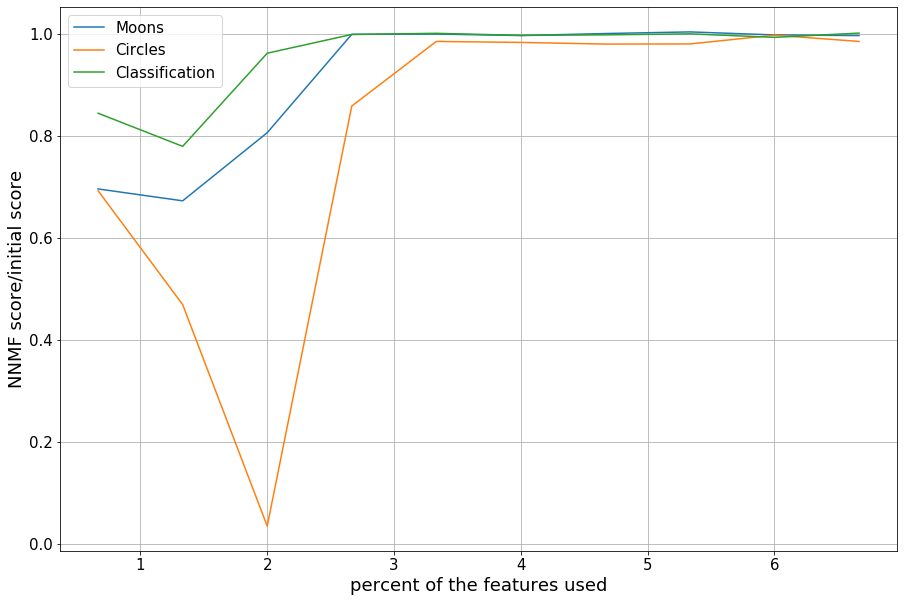

In [44]:
f = plt.figure(figsize=(15,10))
plt.plot(percents*100.0/150, np.array(score2_)[:,0]/np.array(score1_)[:,0], label = names[0])
plt.plot(percents*100.0/150, np.array(score2_)[:,1]/np.array(score1_)[:,1], label = names[1])
plt.plot(percents*100.0/150, np.array(score2_)[:,2]/np.array(score1_)[:,2], label = names[2])
plt.xlabel('percent of the features used', fontsize = 18)
plt.ylabel('NNMF score/initial score', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.legend(fontsize = 15)
plt.show()
f.savefig("score_NNMF_toy.jpg", bbox_inches='tight')

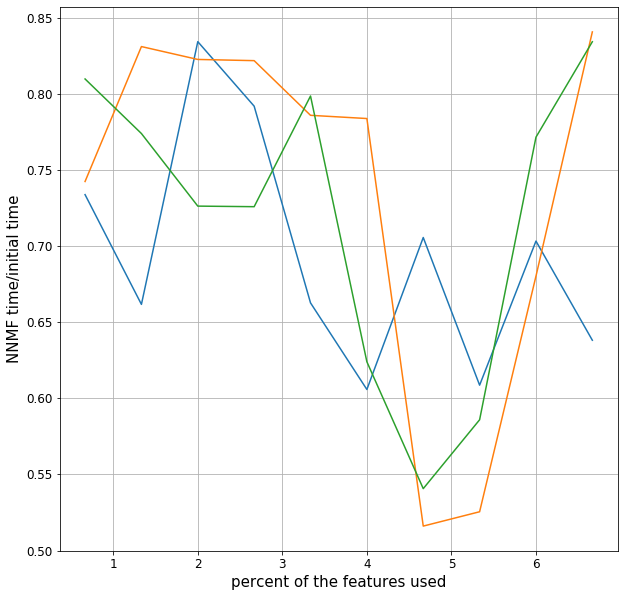

In [29]:
f = plt.figure(figsize=(10,10))
plt.plot(percents*100.0/150, np.array(time2_)[:,0]/np.array(time1_)[:,0], label = names[0])
plt.plot(percents*100.0/150, np.array(time2_)[:,1]/np.array(time1_)[:,1], label = names[1])
plt.plot(percents*100.0/150, np.array(time2_)[:,2]/np.array(time1_)[:,2], label = names[2])
plt.xlabel('percent of the features used')
plt.ylabel('time_NNMF/time_initial')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()
f.savefig("time_NNMF_toy.jpg", bbox_inches='tight')

In [ ]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ffuntik/ML_project_5/blob/master/Toy_examples/Toy%20examples%20NNMF.ipynb)

# NNMF with ICNN on toy examples

## Imports

from sklearn.datasets import make_moons, make_circles, make_classification, load_breast_cancer
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import numpy as np
from sklearn.metrics import f1_score
from statistics import mean
from time import time
from sklearn.decomposition import NMF

## Working with datasets

class Data(torch_data.Dataset):
    def __init__(self, X, y):
        super(Data, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return  self.X[idx], self.y[idx]

## ICNN

class ConvexLayer(nn.Module):
    __constants__ = ['input_features', 'output_features', 'weight', 'bias']

    def __init__(self, input_features, output_features, W, H, bias=False, nmf=False):
        super(ConvexLayer, self).__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.W = torch.Tensor(W)
        self.H = torch.Tensor(H)
        self.nmf = nmf
        
        self.weight = nn.Parameter(torch.Tensor(
            torch.rand(output_features, input_features)
        ))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, input):
        if self.nmf == True:
            output = F.linear(input, self.H)
            linear = F.linear(output, self.W, self.bias)
            #linear = F.linear(input, self.W@self.H, self.bias)
        else:
            linear = F.linear(input, self.weight, self.bias)
        return linear

class DenseICNN(nn.Module):
    def __init__(self, input_dim, output_dim,  hidden_layer_sizes, W, H, activation='celu', dropout=0.3, nmf=False):
        super(DenseICNN, self).__init__()
        
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.droput = dropout
        self.activation = activation

        
        self.quadratic_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, output_features, bias=True),
                nn.Dropout(dropout))
            for output_features in hidden_layer_sizes])
        
        sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.convex_layers = nn.ModuleList([
            nn.Sequential(
                ConvexLayer(input_features, output_features, W=W, H=H, bias=False, nmf=nmf),
                nn.Dropout(dropout))
            for (input_features, output_features) in sizes])
        
        self.final_layer = nn.Linear(hidden_layer_sizes[-1], output_dim, bias=False)
        
                        
    def forward(self, input):
        output = self.quadratic_layers[0](input)
        for quadratic_layer, convex_layer in zip(self.quadratic_layers[1:], self.convex_layers):
            output = convex_layer(output) + quadratic_layer(input)
            if self.activation == 'celu':
                output = torch.celu(output)
        return self.final_layer(output)
    
    def convexify(self):
        for layer in ICNN.convex_layers:
            for sublayer in layer:
                if (isinstance(sublayer, ConvexLayer)):
                    sublayer.weight.data.clamp_(0)

## Training procedure

def train(epochs, ICNN, optimizer, train_loader, scheduler=None, verbose=True, save_dir=None):
    
    for epoch in range(1, epochs+1):
        f1 = []
        ICNN.train()
        for X, y in train_loader:
           
            y_out = ICNN(X)
            loss = criterion(y.unsqueeze(1), torch.sigmoid(y_out))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ICNN.convexify()
            
            
        ICNN.eval()
        for X, y in train_loader:
            
            y_out = ICNN(X)
            test_loss = criterion(y.unsqueeze(1), torch.sigmoid(y_out))
            predY_bin = (torch.sigmoid(y_out).detach().numpy() >= 0.55).astype(np.int)
            trueY_bin = np.expand_dims(y.detach().numpy(), axis=1)
            f1.append(f1_score(trueY_bin.T, predY_bin.T, average='micro', pos_label=None))
            
            
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,50)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), test_loss.item()))
            print('F1 score:', mean(f1))

def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

def NMF_time(ICNN, sample_loader):
    time_ = []
    for X in sample_loader:
        start = time()
        pred = ICNN(X)
        end = time()
        time_.append(end - start)
    return time_

def NMF_score(ICNN, sample_loader):
    for X, y in sample_loader:
        y_out = ICNN(X)
        predY_bin = (torch.sigmoid(y_out).detach().numpy() >= 0.55).astype(np.int)
        trueY_bin = np.expand_dims(y.detach().numpy(), axis=1)
    return f1_score(trueY_bin.T, predY_bin.T, average='micro', pos_label=None)

## Results

toy_examples = {'Moons': make_moons(n_samples=2000, shuffle=True, noise=0.2, random_state=42),
                'Circles': make_circles(n_samples=2000, shuffle=True, noise=0.05, random_state=42),
                'Classification': make_classification(n_samples=2000, n_features=2, n_redundant=0, n_informative=2, n_classes=2, random_state=27)}
names = ['Moons', 'Circles', 'Classification']

fig, ax = plt.subplots(3, 1, figsize=(15,40))

output_dim = 1
hidden_layer_sizes=[150, 100]

percents = np.linspace(1.0, 10, 10)

time1_ = []
time2_ = []
score1_ = []
score2_ = []
for percent in percents:
    model = NMF(n_components=int(percent), init='random', random_state=0)
    time_1 = []
    time_2 = []
    f1_1 = []
    f1_2 = []

    for i in range(len(names)):
        print(names[i] + ' dataset:')

        x, y = toy_examples[names[i]]
        batch_size_train = x.shape[0]//10
        input_dim = x.shape[1]
        dataset = Data(x, y) 

        ICNN = DenseICNN(input_dim, output_dim,  hidden_layer_sizes, W=1, H=1, activation='celu') 
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(ICNN.parameters(), lr=1e-3) 
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)
        data_loader = torch_data.DataLoader(dataset, batch_size=batch_size_train, shuffle=True) 
        train(200, ICNN, optimizer, data_loader, scheduler)

        print()

        W = model.fit_transform(ICNN.convex_layers[0][0].weight.data.detach().numpy())
        H = model.components_

        print(W.shape)
        print(H.shape)

        ICNN_NMF = DenseICNN(input_dim, output_dim,  hidden_layer_sizes, W=W, H=H, activation='celu', nmf=True) 
        ICNN_NMF.eval()
        ICNN.eval()

        ICNN_NMF.quadratic_layers[0][0].weight.data = ICNN.quadratic_layers[0][0].weight.data
        ICNN_NMF.quadratic_layers[1][0].weight.data = ICNN.quadratic_layers[1][0].weight.data
        ICNN_NMF.quadratic_layers[0][0].bias.data = ICNN.quadratic_layers[0][0].bias.data
        ICNN_NMF.quadratic_layers[1][0].bias.data = ICNN.quadratic_layers[1][0].bias.data
        #ICNN_NMF.convex_layers[0][0].bias.data = ICNN.convex_layers[0][0].bias.data
        ICNN_NMF.final_layer.weight.data = ICNN.final_layer.weight.data
        #ICNN_NMF.final_layer.bias.data = ICNN.final_layer.bias.data

        sample_loader1 = torch_data.DataLoader(dataset[:][0], batch_size=1, shuffle=True) 
        sample_loader2 = torch_data.DataLoader(dataset, batch_size=dataset[:][0].shape[0], shuffle=True)

        time1 = NMF_time(ICNN, sample_loader1)
        time2 = NMF_time(ICNN_NMF, sample_loader1)
        time_1.append(np.sum(time1))
        time_2.append(np.sum(time2))

        score1 = NMF_score(ICNN, sample_loader2)
        score2 = NMF_score(ICNN_NMF, sample_loader2)
        f1_1.append(score1)
        f1_2.append(score2)

        xx, yy = get_grid(x)
        pred = ICNN(Data(np.c_[xx.ravel(), yy.ravel()], np.c_[xx.ravel(), yy.ravel()])[:][0])
        zz = 1 - torch.sigmoid(pred).detach().numpy()

        ax[i].contourf(xx, yy, zz.reshape(xx.shape), alpha=0.5, cmap='autumn')
        ax[i].scatter(x[:,0], x[:,1], c=y, cmap = 'autumn_r',edgecolors='black', linewidth=1.5, s=50)
        ax[i].set_xlim(round(x[:,0].min(), 1) - 0.5, round(x[:,0].max(), 1) + 0.5)
        ax[i].set_ylim(round(x[:,1].min(), 1) - 0.5, round(x[:,1].max(), 1) + 0.5)
        ax[i].set_xlabel('Feature 1', fontsize=15)
        ax[i].set_ylabel('Feature 2', fontsize=15)
        ax[i].set_title(names[i] + ' dataset', fontsize=25)

    time1_.append(time_1)
    time2_.append(time_2)

    score1_.append(f1_1)
    score2_.append(f1_2)

f = plt.figure(figsize=(15,10))
plt.plot(percents*100.0/150, np.array(score2_)[:,0]/np.array(score1_)[:,0], label = names[0])
plt.plot(percents*100.0/150, np.array(score2_)[:,1]/np.array(score1_)[:,1], label = names[1])
plt.plot(percents*100.0/150, np.array(score2_)[:,2]/np.array(score1_)[:,2], label = names[2])
plt.xlabel('percent of the features used', fontsize = 18)
plt.ylabel('NNMF score/initial score', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()
plt.legend(fontsize = 15)
plt.show()
f.savefig("score_NNMF_toy.jpg", bbox_inches='tight')

f = plt.figure(figsize=(10,10))
plt.plot(percents*100.0/150, np.array(time2_)[:,0]/np.array(time1_)[:,0], label = names[0])
plt.plot(percents*100.0/150, np.array(time2_)[:,1]/np.array(time1_)[:,1], label = names[1])
plt.plot(percents*100.0/150, np.array(time2_)[:,2]/np.array(time1_)[:,2], label = names[2])
plt.xlabel('percent of the features used')
plt.ylabel('time_NNMF/time_initial')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()
f.savefig("time_NNMF_toy.jpg", bbox_inches='tight')

